# Time Series Forecasting

In [1]:
import pandas as pd

In [2]:
# import segmented customer dataset
df = pd.read_csv('dfp_kmeans2.csv')

# import transaction data
credit = pd.read_excel('datasets/CREDIT CARD TXNS_PJDSC.xlsx')
debit = pd.read_excel('datasets/DEBIT CARD TXNS_PJDSC.xlsx')
digital = pd.read_excel('datasets/FINANCIAL DIGITAL TXNS_PJDSC.xlsx')
incoming = pd.read_excel('datasets/INCOMING INSTAPAY TXNS_PJDSC.xlsx')
outgoing = pd.read_excel('datasets/OUTGOING INSTAPAY TXNS_PJDSC.xlsx')

In [3]:
credit.head()

,CUST_NUM,MERCH_GROUP,DATE,AMOUNT,CHANNEL,MERCH_NAME,COUNTRY
0,3016.966026,Retail Outlet Services,2023-04-01,3211.528727,POS-RETAIL PURCHASE,MERCHANT 1,PH
1,3016.966026,Clothing Stores,2023-04-01,3982.218215,POS-RETAIL PURCHASE,MERCHANT 2,PH
2,3016.966026,Miscellaneous Stores,2023-04-18,872.539734,POS-RETAIL PURCHASE,MERCHANT 3,PH
3,3016.966026,Miscellaneous Stores,2023-04-27,390.082187,POS-RETAIL PURCHASE,MERCHANT 4,PH
4,3016.966026,Retail Outlet Services,2023-04-29,4956.055464,ONLINE-RETAIL PURCHASE,MERCHANT 5,PH


In [4]:
debit.head()

,CUST_NUM,CHANNEL,DATE,TIME,AMOUNT
0,3659.137057,POS,2023-04-01,39958,30001.039678
1,3659.137057,POS,2023-04-04,51349,20001.662634
2,3659.137057,POS,2023-04-05,42803,22001.514584
3,3659.137057,POS,2023-04-06,51455,30001.529392
4,3659.137057,POS,2023-04-11,62752,22001.092602


In [5]:
digital.head()

,CUST_NUM,AMOUNT,DATE_AND_TIME,CHANNEL,TRAN_TYPE
0,4418.325475,2000.885936,2023-04-01 07:55:10,MOBILE,E-WALLET
1,4418.325475,2000.407658,2023-04-01 07:54:01,MOBILE,E-WALLET
2,4418.325475,9829.356544,2023-04-14 11:04:20,MOBILE,BILLS PAYMENT
3,7356.780546,2000.575996,2023-04-11 09:41:43,MOBILE,E-WALLET
4,10768.575579,100.667732,2023-04-02 20:36:51,WEB,E-WALLET


In [6]:
incoming.head()

,CUST_NUM,DATE,TIME,AMOUNT,BPI_ACCT_TYPE,SRC_BANK_NAME
0,5713.401964,2023-04-01,73591,12299.238264,SA,LEMUR
1,5713.401964,2023-04-05,44714,2499.424915,SA,HUMAN
2,5713.401964,2023-04-24,46302,748.744684,SA,HUMAN
3,5713.401964,2023-04-29,40612,1799.144167,SA,HUMAN
4,5713.401964,2023-04-29,24021,1499.628880,SA,HUMAN


In [7]:
outgoing.head()

,CUST_NUM,DATE,TIME,AMOUNT,CHANNEL,RCV_BANK_NAME
0,12844.855858,2023-04-01,68284,999.858929,MOBILE,HUMAN
1,12844.855858,2023-04-01,70887,1999.472786,MOBILE,HUMAN
2,12844.855858,2023-04-02,14934,5099.594826,MOBILE,HUMAN
3,12844.855858,2023-04-02,14025,1799.585649,MOBILE,HUMAN
4,12844.855858,2023-04-04,5845,4299.349369,MOBILE,HUMAN


In [8]:
# Fix digital DATE column to be consistent with the other transaction datasets

digital['DATE'] = digital['DATE_AND_TIME'].dt.strftime('%Y-%m-%d')
digital['DATE'] = pd.to_datetime(digital['DATE'])
digital.head()

,CUST_NUM,AMOUNT,DATE_AND_TIME,CHANNEL,TRAN_TYPE,DATE
0,4418.325475,2000.885936,2023-04-01 07:55:10,MOBILE,E-WALLET,2023-04-01
1,4418.325475,2000.407658,2023-04-01 07:54:01,MOBILE,E-WALLET,2023-04-01
2,4418.325475,9829.356544,2023-04-14 11:04:20,MOBILE,BILLS PAYMENT,2023-04-14
3,7356.780546,2000.575996,2023-04-11 09:41:43,MOBILE,E-WALLET,2023-04-11
4,10768.575579,100.667732,2023-04-02 20:36:51,WEB,E-WALLET,2023-04-02


### Aggregating
First, each transaction dataset will be merged with the segmented customer dataset. Then, we'll aggregate the total transaction volume grouped by the date of transaction.

In [9]:
def aggregator(transaction_data,str):
    transaction_temp = transaction_data[['CUST_NUM', 'AMOUNT', 'DATE']]
    transaction_join = df[['CLUSTER', 'CUST_NUM']].merge(transaction_temp, how='inner', on='CUST_NUM')
    transaction_grouped = transaction_join.groupby(['CLUSTER', 'DATE']).AMOUNT.sum().reset_index()
    transaction_grouped.columns = ['CLUSTER', 'DATE', f'{str}_AMOUNT']
    return transaction_grouped

In [10]:
# Sample
aggregator(debit, 'DEBIT').head()

,CLUSTER,DATE,DEBIT_AMOUNT
0,0,2023-04-01,28739.362317
1,0,2023-04-02,20738.173267
2,0,2023-04-03,12232.278074
3,0,2023-04-04,1022.976876
4,0,2023-04-05,8160.600296


Next, we'll get the sum of all transaction volumes.

In [11]:
data = [credit, debit, digital, incoming, outgoing]
strs = ['CREDIT', 'DEBIT', 'DIGITAL', 'INCOMING', 'OUTGOING']

combined = pd.DataFrame(columns=['CLUSTER', 'DATE'])

for i in range(5):
    transaction_data = data[i]
    str = strs[i]
    agg = aggregator(transaction_data,str)
    combined = combined.merge(agg, how='outer', on=['DATE','CLUSTER'])

combined

,CLUSTER,DATE,CREDIT_AMOUNT,DEBIT_AMOUNT,DIGITAL_AMOUNT,INCOMING_AMOUNT,OUTGOING_AMOUNT
0,0,2023-06-07,12942.821147,1.282082e+04,23551.080320,2.990585e+02,NaN
1,0,2023-06-09,2528.332953,9.406034e+03,22302.285852,1.879766e+04,NaN
2,0,2023-06-10,2530.096903,3.517204e+00,8151.023120,5.597368e+03,NaN
3,0,2023-06-12,10330.449000,8.981721e-01,10000.114437,3.709410e+04,NaN
4,0,2023-06-14,63.419104,1.101914e+04,12673.076327,5.409819e+04,NaN
...,...,...,...,...,...,...,...
454,4,2023-06-26,NaN,5.649058e+06,NaN,1.776956e+06,NaN
455,4,2023-06-27,NaN,7.003543e+06,34051.580700,1.427194e+06,NaN
456,4,2023-06-28,NaN,5.892261e+06,NaN,1.250374e+06,NaN
457,4,2023-06-29,NaN,7.351268e+06,10500.193910,1.963776e+06,NaN


In [12]:
combined = combined.fillna(0)
combined['TOTAL_AMOUNT'] = combined.CREDIT_AMOUNT + combined.DEBIT_AMOUNT + combined.DIGITAL_AMOUNT + combined.INCOMING_AMOUNT + combined.OUTGOING_AMOUNT

combined.sample(5)

,CLUSTER,DATE,CREDIT_AMOUNT,DEBIT_AMOUNT,DIGITAL_AMOUNT,INCOMING_AMOUNT,OUTGOING_AMOUNT,TOTAL_AMOUNT
235,1,2023-05-23,0.000000,1.733970e+06,1.824161e+06,1.236349e+06,0.000000e+00,4.794480e+06
343,3,2023-06-07,0.000000,3.104600e+06,2.955367e+06,2.682548e+06,2.545489e+06,1.128800e+07
211,1,2023-04-29,0.000000,2.753604e+06,2.219990e+06,1.440829e+06,0.000000e+00,6.414423e+06
281,3,2023-04-06,0.000000,2.176505e+06,1.813480e+06,1.782734e+06,1.650629e+06,7.423348e+06
12,2,2023-04-07,184497.862996,4.435059e+05,9.730760e+05,5.551631e+05,1.871169e+05,2.343360e+06


Next, we'll create a dataframe for each cluster.

In [13]:
cluster_combined = {group: group_df for group, group_df in combined.groupby('CLUSTER')}

In [14]:
cluster_combined[0].head() # contains aggregated transactions for all cluster 0 clients

,CLUSTER,DATE,CREDIT_AMOUNT,DEBIT_AMOUNT,DIGITAL_AMOUNT,INCOMING_AMOUNT,OUTGOING_AMOUNT,TOTAL_AMOUNT
0,0,2023-06-07,12942.821147,12820.816190,23551.080320,299.058491,0.0,49613.776148
1,0,2023-06-09,2528.332953,9406.034155,22302.285852,18797.659167,0.0,53034.312128
2,0,2023-06-10,2530.096903,3.517204,8151.023120,5597.368035,0.0,16282.005261
3,0,2023-06-12,10330.449000,0.898172,10000.114437,37094.095562,0.0,57425.557171
4,0,2023-06-14,63.419104,11019.135376,12673.076327,54098.188636,0.0,77853.819443


Let's try visualizing the data first before proceeding to the time series forecasting.

In [15]:
import warnings

# Filter FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning, module='seaborn')

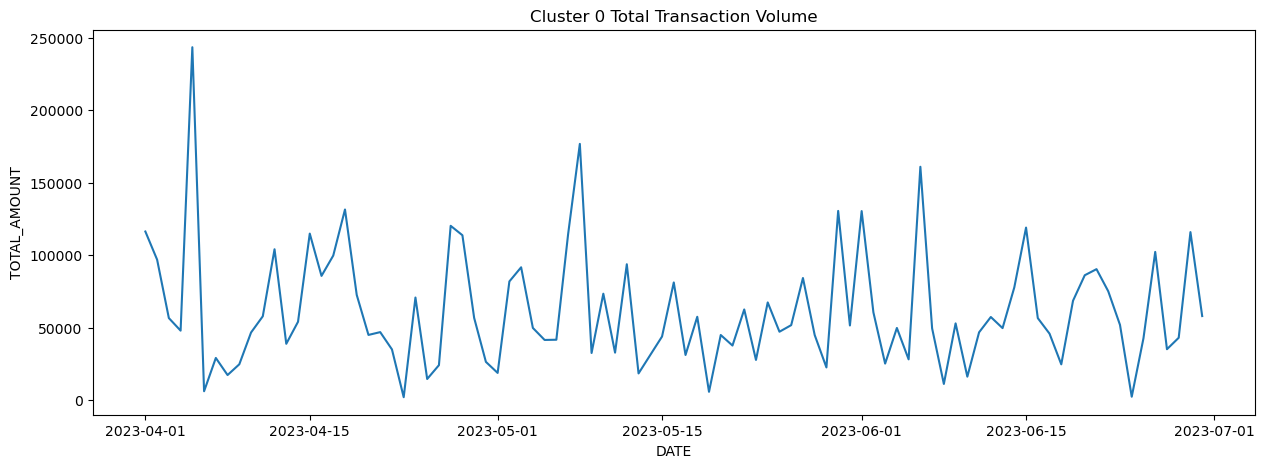

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,5))
sns.lineplot(x='DATE', y='TOTAL_AMOUNT', data=cluster_combined[0])
plt.title('Cluster 0 Total Transaction Volume')
plt.show()

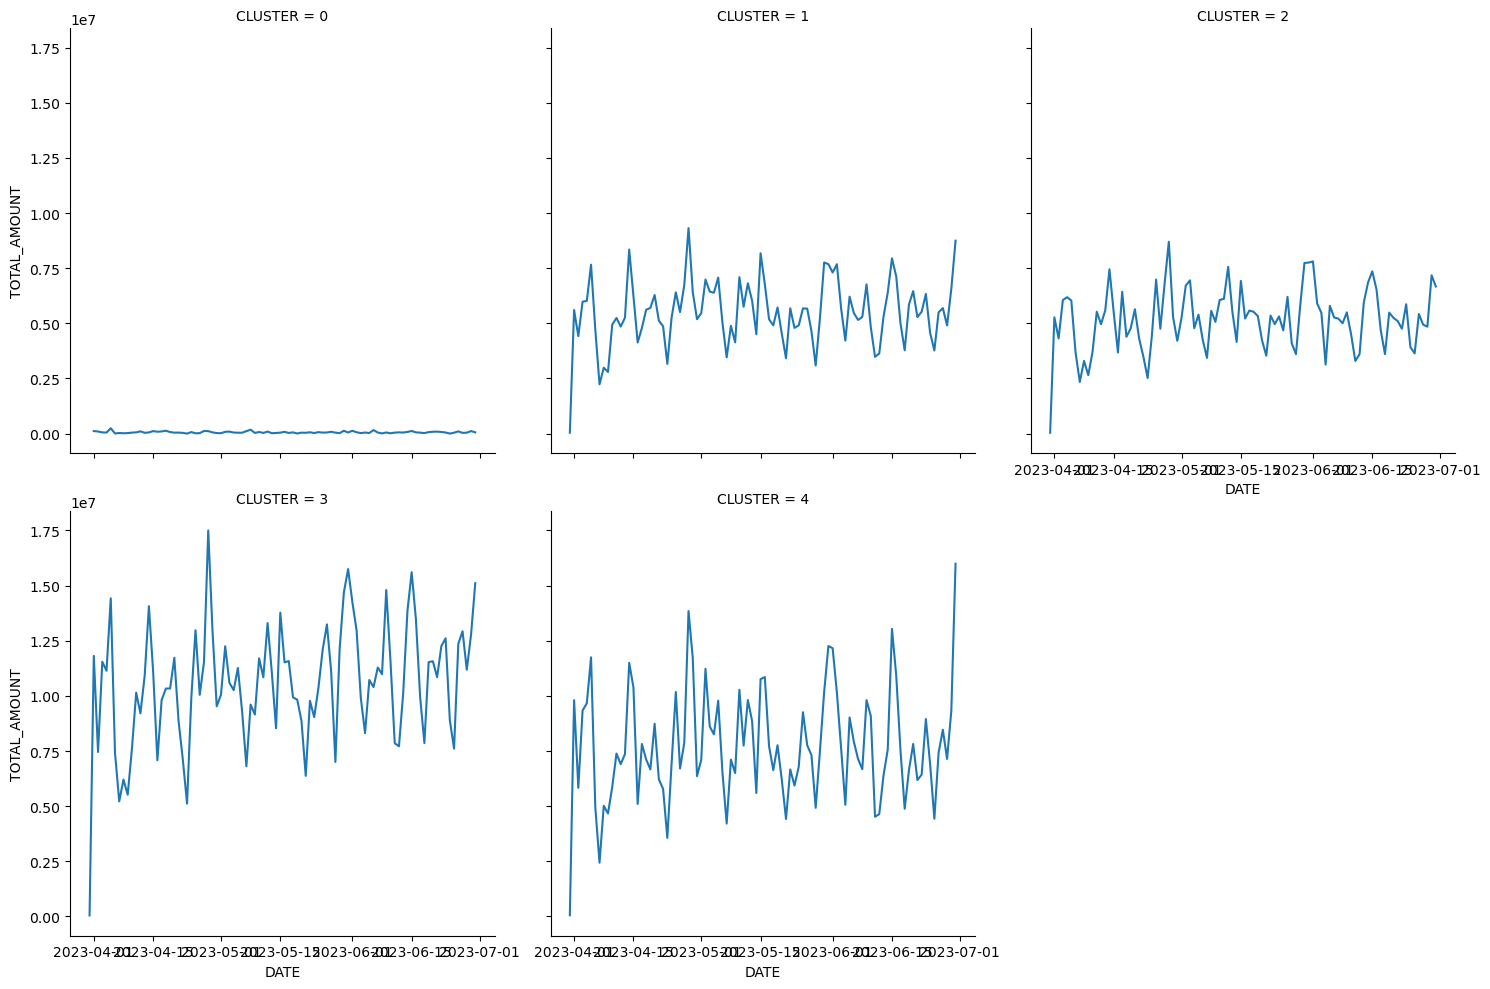

In [17]:
g = sns.FacetGrid(combined, col='CLUSTER', col_wrap=3, height=5)
g.map(sns.lineplot,'DATE', 'TOTAL_AMOUNT')
plt.savefig('Total Transaction Volume by Cluster.jpg')
plt.show()

### Forecasting
Given the dataset, we can use `Prophet` to forecast total transaction volume. Prophet is an open-source tool from Facebook used for forecasting time series data which helps businesses understand and gain insights about the market. It is based on a decomposable additive model where non-linear trends fit with seasonality, able to handle messy data.

In [18]:
import warnings

# Filter FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [19]:
from prophet import Prophet

C:\Users\USER\.conda\envs\pjdsc\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [20]:
# Cluster 0
d = cluster_combined[0][['DATE', 'TOTAL_AMOUNT']]
d.columns = ['ds','y']

In [21]:
model = Prophet()
model.fit(d)

05:53:25 - cmdstanpy - INFO - Chain [1] start processing
05:53:25 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
# Forecast for next month
n_pred = 30
future = model.make_future_dataframe(periods=n_pred, freq='D')

In [23]:
forecast = model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
116,2023-07-26,51572.927093,19584.914033,120282.122967,51572.925155,51572.928894,16791.986587,16791.986587,16791.986587,16791.986587,16791.986587,16791.986587,0.0,0.0,0.0,68364.913681
117,2023-07-27,51427.647596,6388.849459,104928.456716,51427.645570,51427.649508,3791.815575,3791.815575,3791.815575,3791.815575,3791.815575,3791.815575,0.0,0.0,0.0,55219.463171
118,2023-07-28,51282.368099,-7326.783079,93932.052507,51282.365982,51282.370145,-6255.268700,-6255.268700,-6255.268700,-6255.268700,-6255.268700,-6255.268700,0.0,0.0,0.0,45027.099398
119,2023-07-29,51137.088601,-14321.070038,86215.835849,51137.086373,51137.090749,-14622.252288,-14622.252288,-14622.252288,-14622.252288,-14622.252288,-14622.252288,0.0,0.0,0.0,36514.836313
120,2023-07-30,50991.809104,-13708.450143,88665.466362,50991.806806,50991.811372,-13801.324570,-13801.324570,-13801.324570,-13801.324570,-13801.324570,-13801.324570,0.0,0.0,0.0,37190.484534


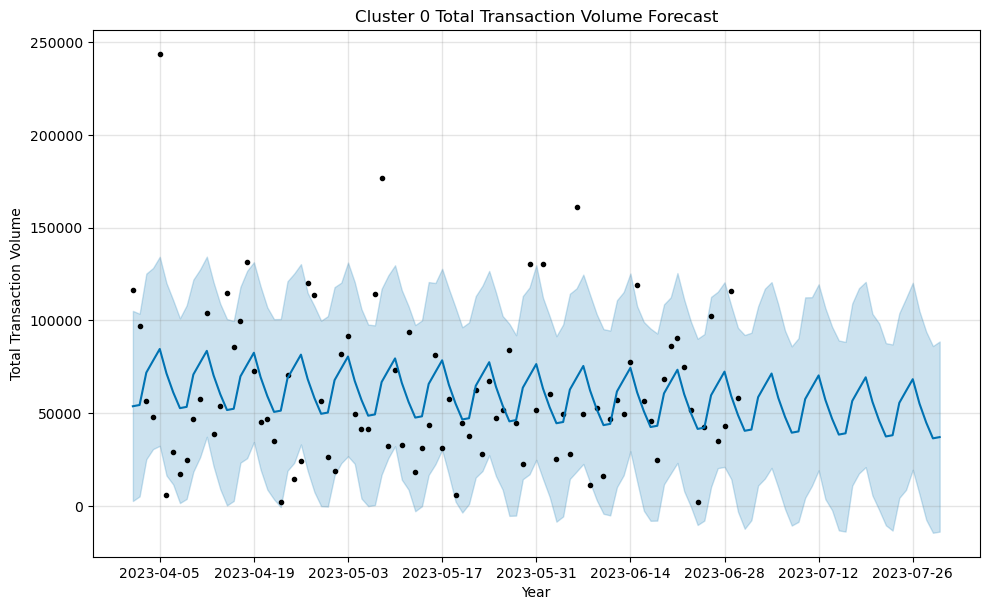

In [24]:
fig = model.plot(forecast)

plt.title('Cluster 0 Total Transaction Volume Forecast')
plt.xlabel('Year')
plt.ylabel('Total Transaction Volume')

plt.savefig('Forecast/Cluster 0 Total Transaction Volume 30-day Forecast.jpg')
plt.show()

In [26]:
def forecaster(transaction_data, str, fcst):
    t = transaction_data[['DATE', 'TOTAL_AMOUNT']]
    t.columns = ['ds','y']

    model = Prophet()
    model.fit(t)

    future = model.make_future_dataframe(periods=fcst[0], freq=fcst[-1])
    forecast = model.predict(future)

    fig = model.plot(forecast)
    
    plt.title(str)
    plt.xlabel('Year')
    plt.ylabel('Total Transaction Volume')

    plt.savefig(f'Forecast/{str}.jpg')
    plt.show()

23:58:27 - cmdstanpy - INFO - Chain [1] start processing
23:58:28 - cmdstanpy - INFO - Chain [1] done processing


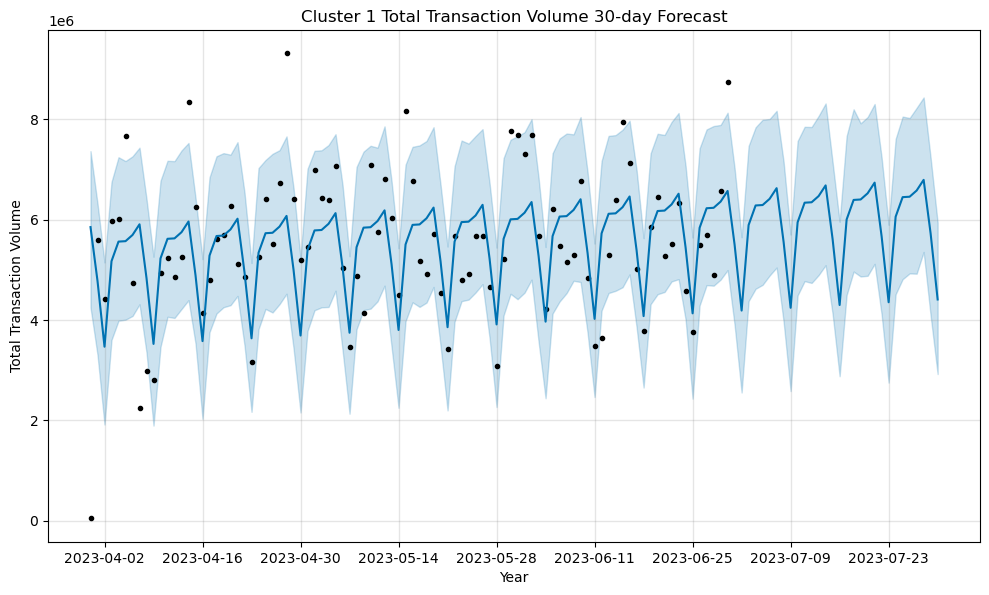

In [191]:
forecaster(cluster_combined[1], 'Cluster 1 Total Transaction Volume 30-day Forecast', (30,'D'))

23:58:50 - cmdstanpy - INFO - Chain [1] start processing
23:58:50 - cmdstanpy - INFO - Chain [1] done processing


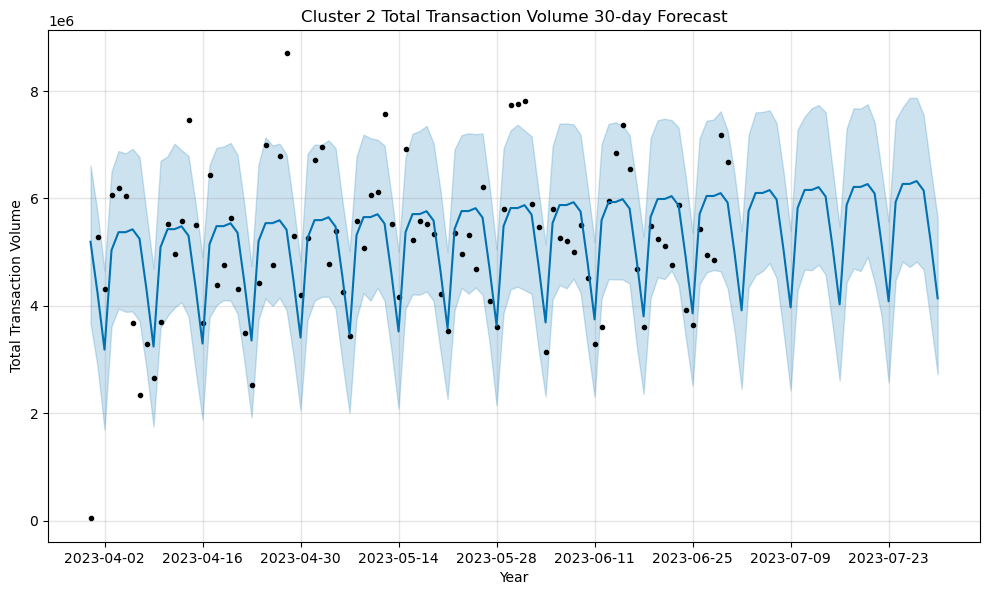

In [192]:
forecaster(cluster_combined[2], 'Cluster 2 Total Transaction Volume 30-day Forecast', (30,'D'))

23:59:03 - cmdstanpy - INFO - Chain [1] start processing
23:59:04 - cmdstanpy - INFO - Chain [1] done processing


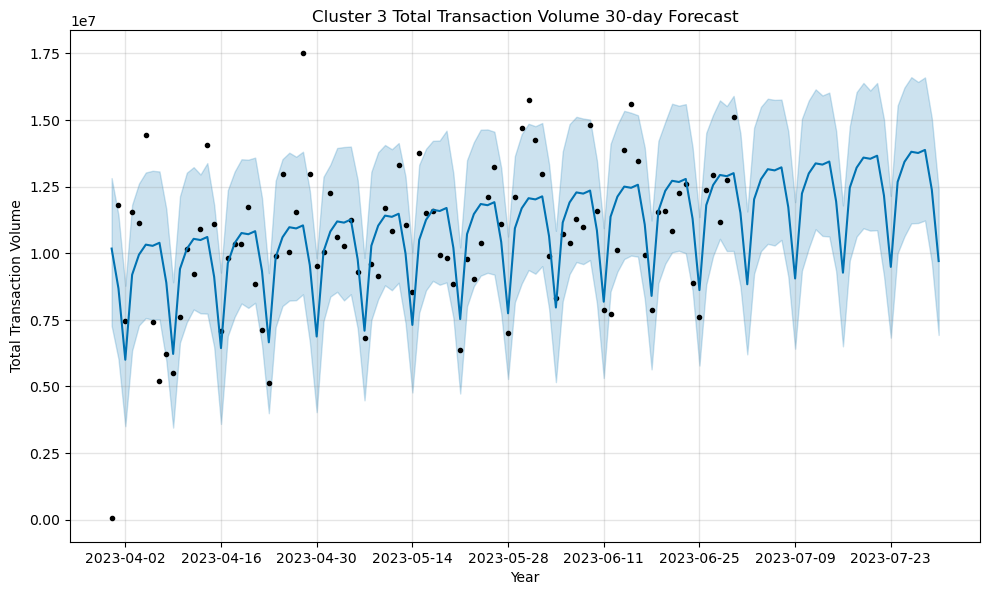

In [193]:
forecaster(cluster_combined[3], 'Cluster 3 Total Transaction Volume 30-day Forecast', (30,'D'))

23:59:34 - cmdstanpy - INFO - Chain [1] start processing
23:59:34 - cmdstanpy - INFO - Chain [1] done processing


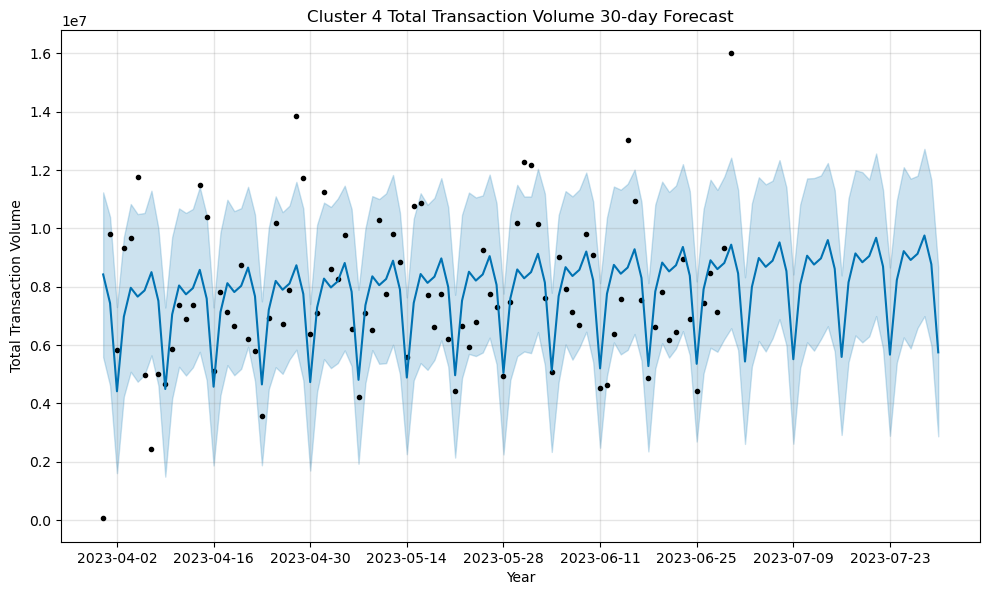

In [194]:
forecaster(cluster_combined[4], 'Cluster 4 Total Transaction Volume 30-day Forecast', (30,'D'))

In [27]:
def forecaster_components(transaction_data, str, fcst):
    t = transaction_data[['DATE', 'TOTAL_AMOUNT']]
    t.columns = ['ds','y']

    model = Prophet()
    model.fit(t)

    future = model.make_future_dataframe(periods=fcst[0], freq=fcst[-1])
    forecast = model.predict(future)

    fig = model.plot_components(forecast)
    plt.title(str)

    plt.savefig(f'Forecast/{str}.jpg')
    plt.show()

05:55:45 - cmdstanpy - INFO - Chain [1] start processing
05:55:46 - cmdstanpy - INFO - Chain [1] done processing


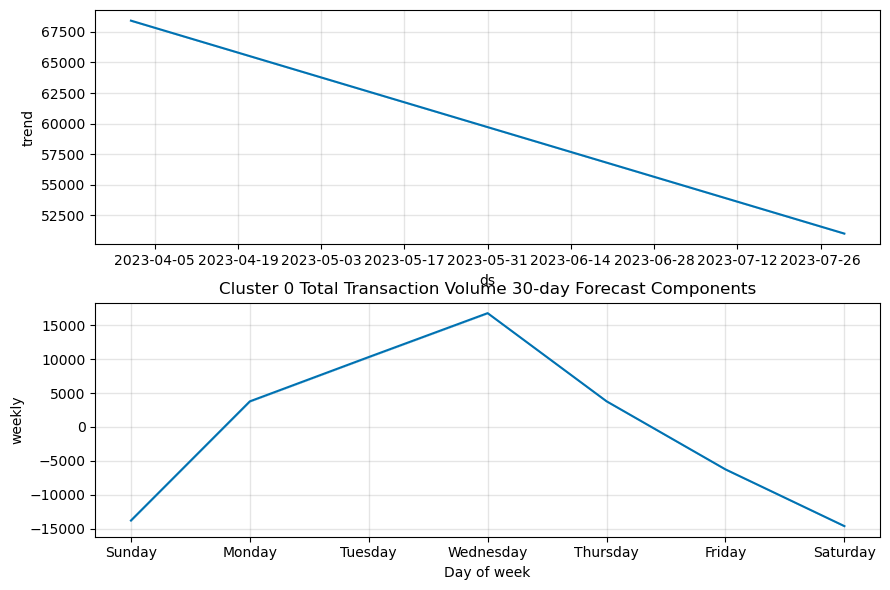

05:55:47 - cmdstanpy - INFO - Chain [1] start processing
05:55:47 - cmdstanpy - INFO - Chain [1] done processing


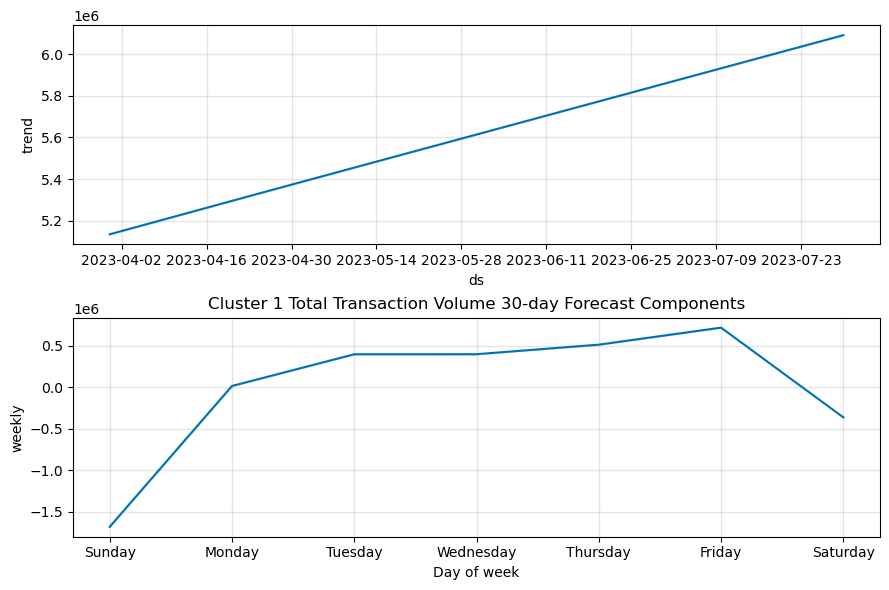

05:55:48 - cmdstanpy - INFO - Chain [1] start processing
05:55:48 - cmdstanpy - INFO - Chain [1] done processing


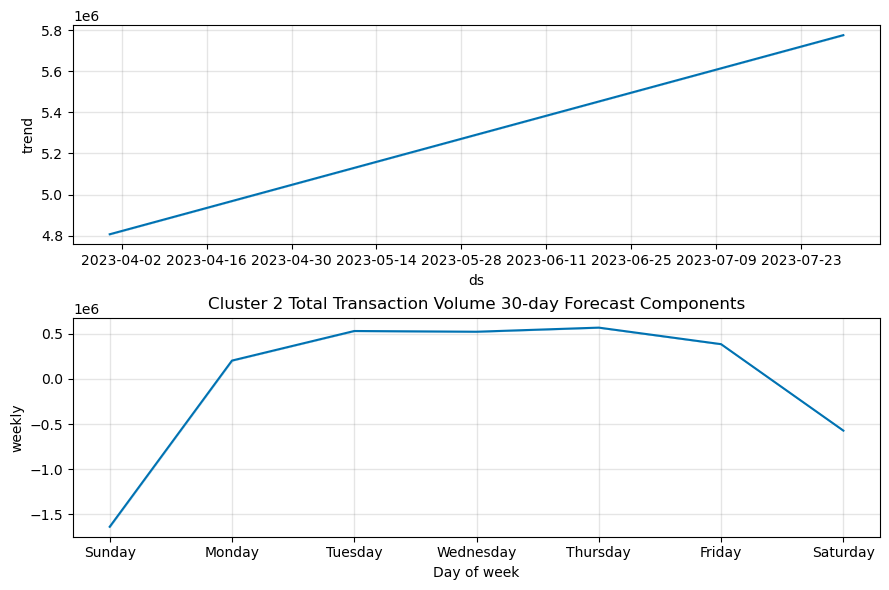

05:55:49 - cmdstanpy - INFO - Chain [1] start processing
05:55:49 - cmdstanpy - INFO - Chain [1] done processing


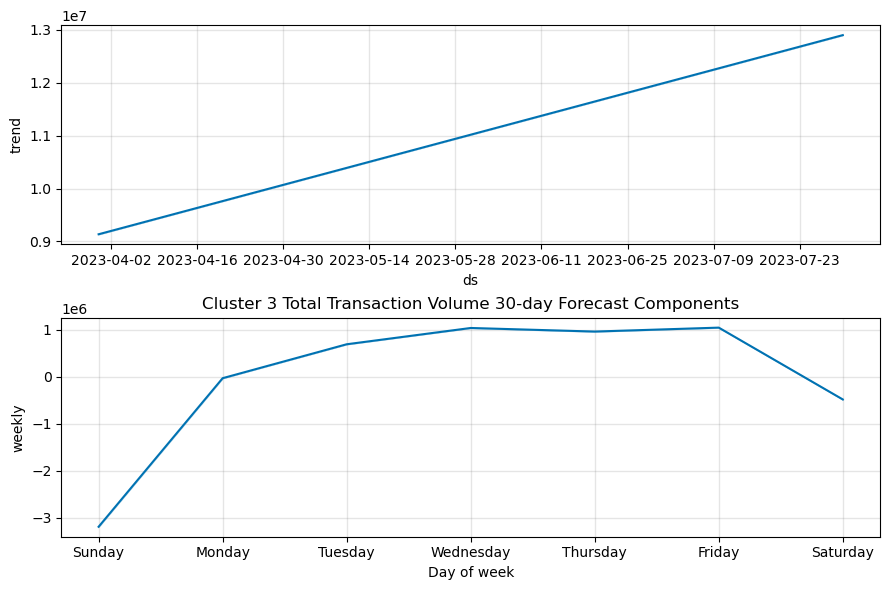

05:55:50 - cmdstanpy - INFO - Chain [1] start processing
05:55:50 - cmdstanpy - INFO - Chain [1] done processing


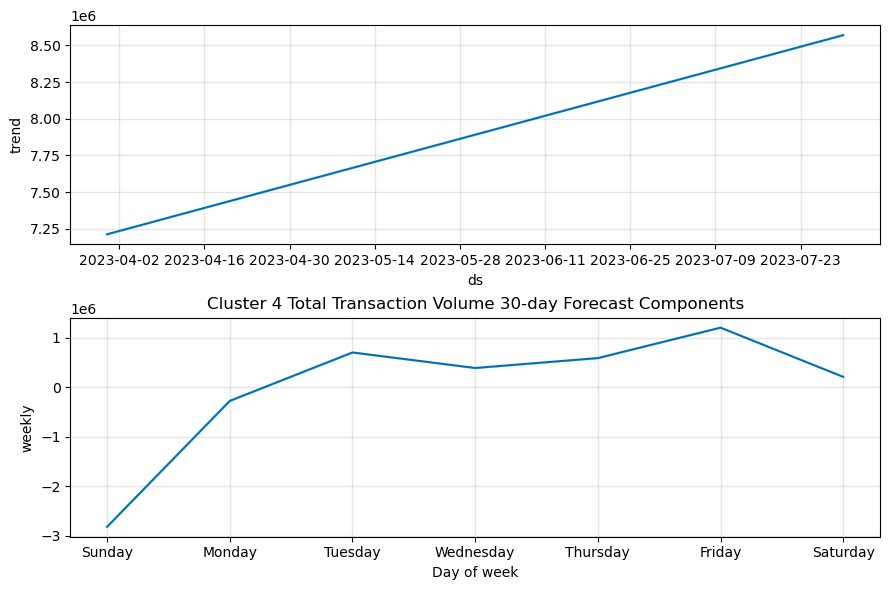

In [28]:
for i in range(5):
    forecaster_components(cluster_combined[i], f'Cluster {i} Total Transaction Volume 30-day Forecast Components', (30,'D'))